In [1]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score, f1_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score

In [2]:
pd.set_option('display.max_rows', 450)  # показывать больше строк
pd.set_option('display.max_columns', 150)  # показывать больше колонок

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df_test.loc[:, 'label'] = 0
df_test.loc[:, 'default'] = 0
df_train.loc[:, 'label'] = 1
df = df_train.append(df_test, sort=False).reset_index(drop=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [6]:
df.loc[:, 'app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')

In [7]:
df.app_date.describe()

count                  110148
unique                    120
top       2014-03-18 00:00:00
freq                     1491
first     2014-01-01 00:00:00
last      2014-04-30 00:00:00
Name: app_date, dtype: object

In [8]:
df.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

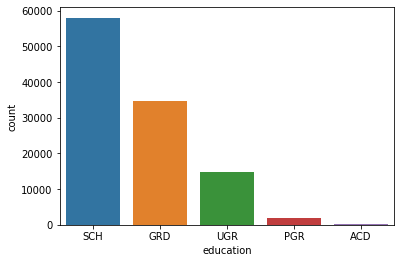

In [9]:
sns.countplot(df.education)

In [10]:
df.loc[:, 'education'] = df['education'].fillna('SCH')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  datetime64[ns]
 2   education         110148 non-null  object        
 3   sex               110148 non-null  object        
 4   age               110148 non-null  int64         
 5   car               110148 non-null  object        
 6   car_type          110148 non-null  object        
 7   decline_app_cnt   110148 non-null  int64         
 8   good_work         110148 non-null  int64         
 9   score_bki         110148 non-null  float64       
 10  bki_request_cnt   110148 non-null  int64         
 11  region_rating     110148 non-null  int64         
 12  home_address      110148 non-null  int64         
 13  work_address      110148 non-null  int64         
 14  inco

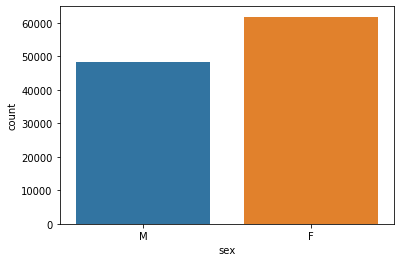

In [12]:
sns.countplot(df.sex)

In [13]:
label_encoder = LabelEncoder()

df.loc[:, 'sex'] = label_encoder.fit_transform(df['sex'])

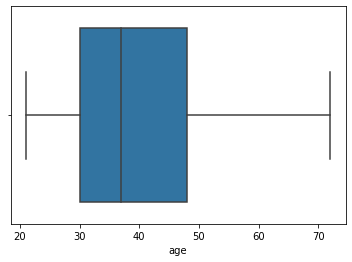

In [14]:
sns.boxplot(df.age)

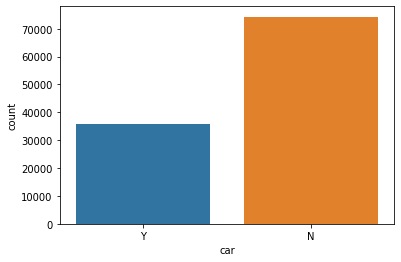

In [15]:
sns.countplot(df.car)

In [16]:
label_encoder = LabelEncoder()

df.loc[:, 'car'] = label_encoder.fit_transform(df['car'])

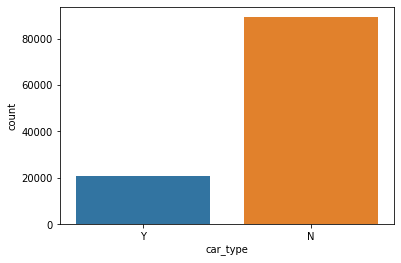

In [17]:
sns.countplot(df.car_type)

In [18]:
label_encoder = LabelEncoder()

df.loc[:, 'car_type'] = label_encoder.fit_transform(df['car_type'])

Проверим нет ли противоречий: когда указано, что нет машини, но есть иномарка.


In [19]:
df[df.car == 0].car_type.value_counts()

0    74290
Name: car_type, dtype: int64

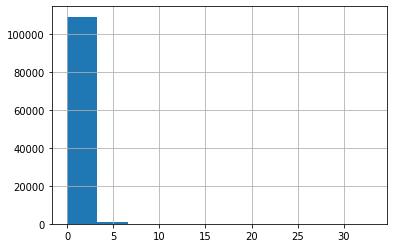

In [20]:
df.decline_app_cnt.hist()

In [21]:
df['decline_app_cnt'] = np.log(df['decline_app_cnt'] + 1)

In [22]:
df.good_work.unique()

array([0, 1])

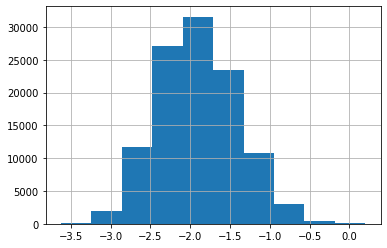

In [23]:
df.score_bki.hist()

In [24]:
df.score_bki.describe()

count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64

In [25]:
def detect_outlires(col):
    quan_25 = np.quantile(df[col], 0.25)
    quan_75 = np.quantile(df[col], 0.75)
    IQR = quan_75 - quan_25
    return len(df[(df[col] < quan_25 - 1.5 * IQR) |
                  (df[col] > quan_75 +
                   1.5 * IQR)]), quan_25 - 1.5 * IQR, quan_75 + 1.5 * IQR


display(detect_outlires('score_bki'))

(518, -3.299251946250001, -0.5290698762499992)

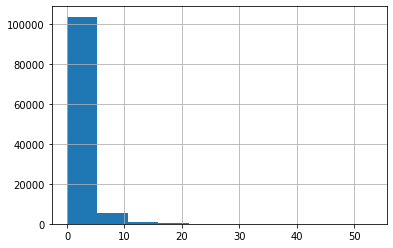

In [26]:
df.bki_request_cnt.hist()

In [27]:
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)

In [28]:
detect_outlires('bki_request_cnt')

(15, -2.0794415416798357, 3.465735902799726)

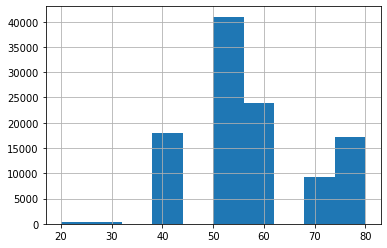

In [29]:
df.region_rating.hist()

In [30]:
detect_outlires('region_rating')

(17917, 35.0, 75.0)

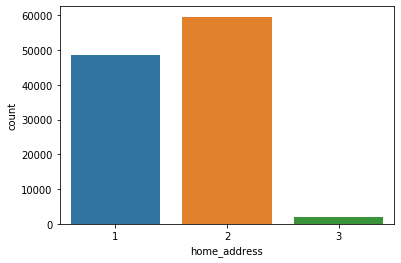

In [31]:
sns.countplot(df.home_address)

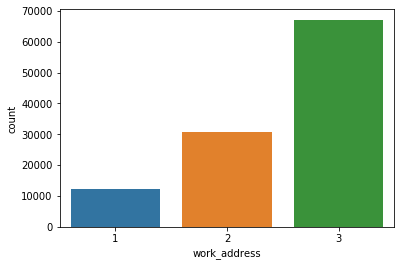

In [32]:
sns.countplot(df.work_address)

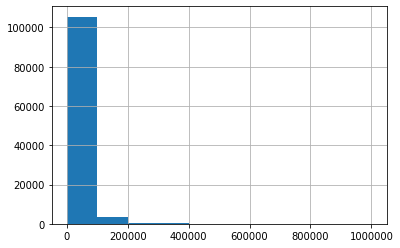

In [33]:
df.income.hist()

In [34]:
df['income'] = np.log(df['income'] + 1)

In [35]:
detect_outlires('income')

(2609, 8.590378193705899, 12.092136480586621)

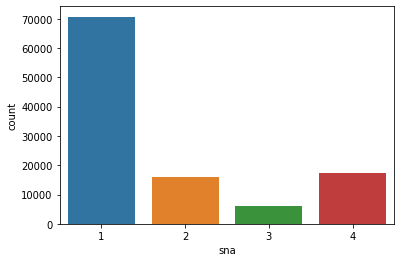

In [36]:
sns.countplot(df.sna)

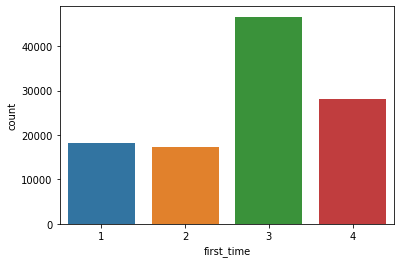

In [37]:
sns.countplot(df.first_time)

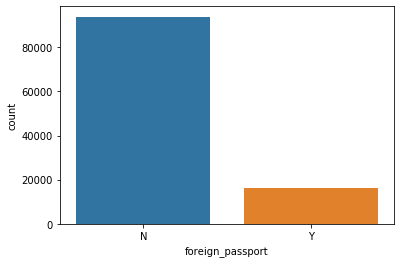

In [38]:
sns.countplot(df.foreign_passport)

In [39]:
label_encoder = LabelEncoder()

df.loc[:, 'foreign_passport'] = label_encoder.fit_transform(
    df['foreign_passport'])

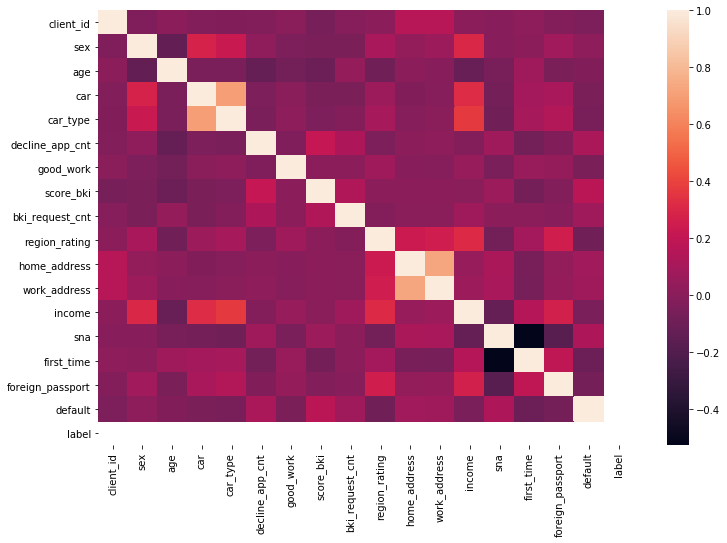

In [40]:
plt.figure(figsize=[12, 8])
sns.heatmap(df[df['label'] == 1].corr())

In [41]:
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']
for col in cat_cols:
    dummy_df = pd.get_dummies(df[col])
    dummy_columns = []
    for name in dummy_df.columns:
        dummy_columns.append('{}_{}'.format(col, name))
    dummy_df.columns = dummy_columns
    df = pd.concat([df.drop(col, axis=1), dummy_df], axis=1)

In [42]:
df.loc[:, 'app_date'] = (df['app_date'] - df['app_date'].min()).dt.days

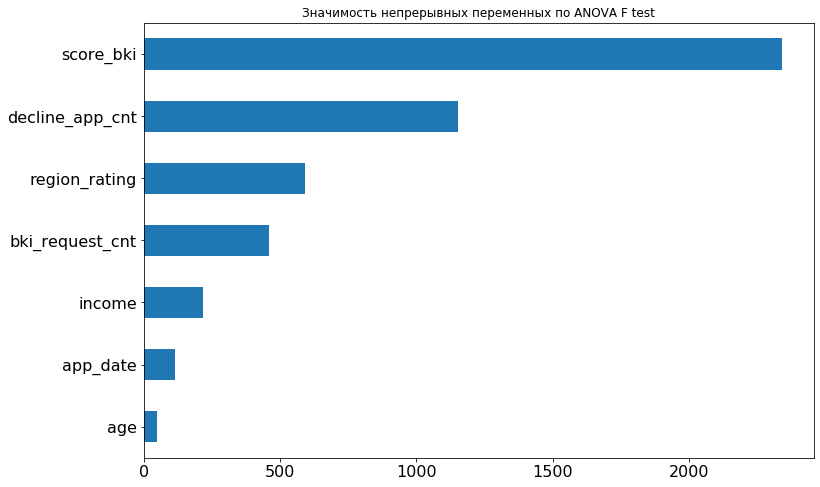

In [43]:
plt.figure(figsize=[12, 8])
num_cols = [
    'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income', 'app_date',
    'age', 'region_rating'
]
temp_df = df[df['label'] == 1]
imp_num = pd.Series(f_classif(temp_df[num_cols], temp_df['default'])[0],
                    index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh',
             fontsize=16,
             title='Значимость непрерывных переменных по ANOVA F test')

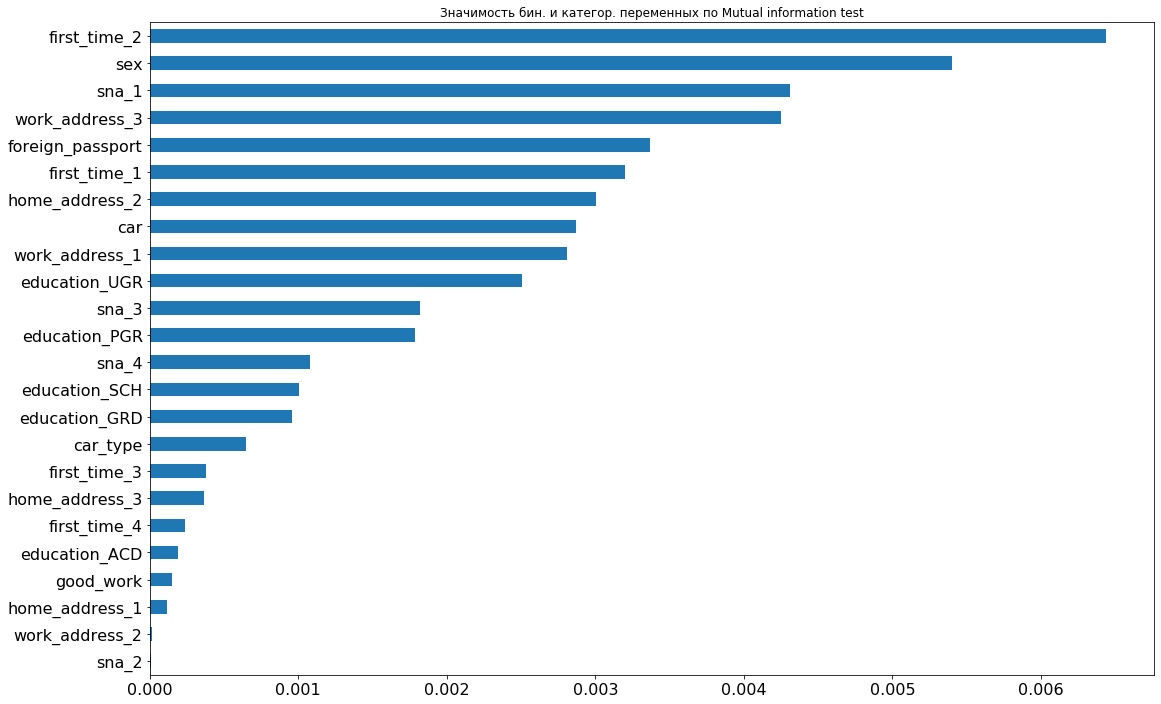

In [44]:
plt.figure(figsize=[18, 12])
cat_cols = list(df.columns[15:])
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
temp_df = df[df['label'] == 1]

imp_cat = pd.Series(mutual_info_classif(temp_df[bin_cols + cat_cols],
                                        temp_df['default'],
                                        discrete_features=True),
                    index=cat_cols + bin_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(
    kind='barh',
    fontsize=16,
    title='Значимость бин. и категор. переменных по Mutual information test')

In [45]:
df.loc[:, num_cols] = np.vstack([
    StandardScaler().fit_transform(df[df['label'] == 1][num_cols]),
    StandardScaler().fit_transform(df[df['label'] == 0][num_cols])
])

In [46]:
from sklearn.preprocessing import PolynomialFeatures
for comb in list(combinations(num_cols, 2)):
    pf = PolynomialFeatures(2)
    poly = pd.DataFrame(pf.fit_transform(df[list(comb)]))
    display(
        comb,
        pd.concat([df, poly.iloc[:, :]], axis=1).corr()['default'].iloc[-6:])

('score_bki', 'decline_app_cnt')

0         NaN
1    0.140220
2    0.099168
3    0.044200
4    0.056676
5    0.084259
Name: default, dtype: float64

('score_bki', 'bki_request_cnt')

0         NaN
1    0.140220
2    0.062767
3    0.044200
4    0.023182
5    0.020965
Name: default, dtype: float64

('score_bki', 'income')

0         NaN
1    0.140220
2   -0.043074
3    0.044200
4   -0.014297
5   -0.017457
Name: default, dtype: float64

('score_bki', 'app_date')

0         NaN
1    0.140220
2   -0.031481
3    0.044200
4   -0.006609
5   -0.009876
Name: default, dtype: float64

('score_bki', 'age')

0         NaN
1    0.140220
2   -0.019992
3    0.044200
4    0.003414
5   -0.000016
Name: default, dtype: float64

('score_bki', 'region_rating')

0         NaN
1    0.140220
2   -0.071189
3    0.044200
4   -0.017405
5   -0.029277
Name: default, dtype: float64

('decline_app_cnt', 'bki_request_cnt')

0         NaN
1    0.099168
2    0.062767
3    0.084259
4    0.031838
5    0.020965
Name: default, dtype: float64

('decline_app_cnt', 'income')

0         NaN
1    0.099168
2   -0.043074
3    0.084259
4   -0.008096
5   -0.017457
Name: default, dtype: float64

('decline_app_cnt', 'app_date')

0         NaN
1    0.099168
2   -0.031481
3    0.084259
4   -0.008662
5   -0.009876
Name: default, dtype: float64

('decline_app_cnt', 'age')

0         NaN
1    0.099168
2   -0.019992
3    0.084259
4   -0.029384
5   -0.000016
Name: default, dtype: float64

('decline_app_cnt', 'region_rating')

0         NaN
1    0.099168
2   -0.071189
3    0.084259
4   -0.016253
5   -0.029277
Name: default, dtype: float64

('bki_request_cnt', 'income')

0         NaN
1    0.062767
2   -0.043074
3    0.020965
4    0.006285
5   -0.017457
Name: default, dtype: float64

('bki_request_cnt', 'app_date')

0         NaN
1    0.062767
2   -0.031481
3    0.020965
4   -0.003149
5   -0.009876
Name: default, dtype: float64

('bki_request_cnt', 'age')

0         NaN
1    0.062767
2   -0.019992
3    0.020965
4    0.004522
5   -0.000016
Name: default, dtype: float64

('bki_request_cnt', 'region_rating')

0         NaN
1    0.062767
2   -0.071189
3    0.020965
4   -0.000290
5   -0.029277
Name: default, dtype: float64

('income', 'app_date')

0         NaN
1   -0.043074
2   -0.031481
3   -0.017457
4    0.003280
5   -0.009876
Name: default, dtype: float64

('income', 'age')

0         NaN
1   -0.043074
2   -0.019992
3   -0.017457
4    0.001703
5   -0.000016
Name: default, dtype: float64

('income', 'region_rating')

0         NaN
1   -0.043074
2   -0.071189
3   -0.017457
4   -0.025903
5   -0.029277
Name: default, dtype: float64

('app_date', 'age')

0         NaN
1   -0.031481
2   -0.019992
3   -0.009876
4    0.002616
5   -0.000016
Name: default, dtype: float64

('app_date', 'region_rating')

0         NaN
1   -0.031481
2   -0.071189
3   -0.009876
4    0.009880
5   -0.029277
Name: default, dtype: float64

('age', 'region_rating')

0         NaN
1   -0.019992
2   -0.071189
3   -0.000016
4    0.011299
5   -0.029277
Name: default, dtype: float64

In [48]:
test = df.copy()

Возьмем всевозможные пары признаков и добавим полиномиальные признаки, где корреляция с целевой переменной больше 0.08

In [49]:
best_comb = []
for comb in list(combinations(bin_cols + cat_cols + num_cols, 2)):
    comb = list(comb)
    pf = PolynomialFeatures(2)
    poly = pd.DataFrame(pf.fit_transform(df[df['label'] == 1][comb]))
    res = pd.concat([df[df['label'] == 1], poly.iloc[:, :]],
                    axis=1).corr()['default'].iloc[-2]
    if res > 0.08:
        best_comb.append(comb)

In [50]:
for comb in best_comb:
    pf = PolynomialFeatures(2)
    poly = pd.DataFrame(pf.fit_transform(test[comb]))
    test = pd.concat([test, poly.iloc[:, [4]]], axis=1)

Продублируем строки с дефолтами, чтобы сделать выборку более сбалансированной

In [51]:
test = pd.concat([test, test[test['default'] == 1]])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    test[(test['label'] == 1)].drop(
        ['label', 'default', 'client_id', 'sna_2', 'work_address_2'], axis=1),
    test[test['label'] == 1]['default'],
    test_size=0.2,
    random_state=42)
model = LogisticRegression(C=1.0,
                           class_weight='balanced',
                           dual=False,
                           fit_intercept=True,
                           intercept_scaling=1,
                           l1_ratio=None,
                           max_iter=1000,
                           multi_class='auto',
                           n_jobs=None,
                           penalty='l2',
                           random_state=42,
                           solver='lbfgs',
                           tol=0.001,
                           verbose=0,
                           warm_start=False)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:, 1]
roc_auc_score(y_test, y_pred)

0.7461846026079948

Найдем лучшие параметры для roc_auc и f1_score

In [58]:
model = LogisticRegression(random_state=42)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'lbfgs'],
        'class_weight': ['none', 'balanced'],
        'multi_class': ['auto', 'ovr'],
        'max_iter': [iter_],
        'tol': [epsilon_stop]
    },
    {
        'penalty': ['l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'class_weight': ['none', 'balanced'],
        'multi_class': ['auto', 'ovr'],
        'max_iter': [iter_],
        'tol': [epsilon_stop]
    },
    {
        'penalty': ['none'],
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
        'class_weight': ['none', 'balanced'],
        'multi_class': ['auto', 'ovr'],
        'max_iter': [iter_],
        'tol': [epsilon_stop]
    },
]
gridsearch = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
# печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'lbfgs'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6758
Precision: 0.3821
Recall: 0.6931
F1: 0.4926


/home/vlad/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [53]:
model = LogisticRegression(random_state=42)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'lbfgs'],
        'class_weight': ['none', 'balanced'],
        'multi_class': ['auto', 'ovr'],
        'max_iter': [iter_],
        'tol': [epsilon_stop]
    },
    {
        'penalty': ['l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'class_weight': ['none', 'balanced'],
        'multi_class': ['auto', 'ovr'],
        'max_iter': [iter_],
        'tol': [epsilon_stop]
    },
    {
        'penalty': ['none'],
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
        'class_weight': ['none', 'balanced'],
        'multi_class': ['auto', 'ovr'],
        'max_iter': [iter_],
        'tol': [epsilon_stop]
    },
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
# печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'newton-cg'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6755
Precision: 0.3820
Recall: 0.6947
F1: 0.4930


Итоговые метрики показывают, что даже после всех мер по улучшения баланса между классами(дублирование дефолтных клиентов и параметр сlass_weight='balanced' для модели), ошибка второго рода все равно немаленькая. Но в любом случае она во много раз больше изначальной.

In [61]:
# печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

Accuracy: 0.6755
Precision: 0.3820
Recall: 0.6947
F1: 0.4930


Предсказываем значение на тестовой выборке(label = 0) и сохраняем в файл

In [64]:
y_pred_kag = model.predict_proba(test[(test['label'] == 0)].drop(
    ['label', 'default', 'client_id', 'sna_2', 'work_address_2'], axis=1))
y_pred_kag = y_pred_kag[:, 1]

kag_res = pd.DataFrame(np.array([df[df['label'] == 0].client_id,
                                 y_pred_kag]).T,
                       columns=['client_id', 'default'])
kag_res['client_id'] = kag_res['client_id'].astype('int64')
kag_res.to_csv('kaggle_result.csv')
kag_res = pd.read_csv('kaggle_result.csv', index_col='client_id')
kag_res.drop(['Unnamed: 0'], axis=1).to_csv('kaggle_result.csv')